## 动物百科AI老师
### 0. 源起
小时候就很喜欢看动物世界，常常被非洲大草原上各种壮观的动物迁徙所震撼。后来自己的论文研究方向是生物集群运动，不得不说也是一件有意思的巧合了。虽然我喜欢看各种动物，近几年还去了好几次动物园，但其实很多动物都不认识。偶尔带小朋友，看到小朋友的看图识动物卡片，有时候自己也不认识，就常常想要是有个APP能够自动识图并给出有趣的讲解就好了。

若干年前，做这样一个动物百科AI老师并没有那么容易，现在基于百度PaddleHub开源的动物识别模型，我们可以轻松实现其中的AI识图核心功能，再加上一些爬虫技巧，就能实现讲解内容的提取功能。简单两步，一个具备核心功能的动物百科AI老师就能实现了。

### 1. PaddleHub动物识别模型
这里使用[resnet50_vd_animals](https://www.paddlepaddle.org.cn/hubdetail?name=resnet50_vd_animals&en_category=ImageClassification)

#### 模型概述
ResNet-vd 其实就是 ResNet-D，是ResNet 原始结构的变种，可用于图像分类和特征提取。该 PaddleHub Module 采用百度自建动物数据集训练得到，支持7978种动物的分类识别。

*也可以使用[mobilenet_v2_animals](https://www.paddlepaddle.org.cn/hubdetail?name=mobilenet_v2_animals&en_category=ImageClassification), 二者数据集一样，只是模型架构不同。*

### 2. 安装依赖

In [1]:
!pip install -r requirements.txt

In [2]:
!pip list | grep paddle
!pip list | grep opencv
!pip list | grep requests-html
!pip list | grep Pillow

paddlehub              1.6.0          
paddlepaddle           1.8.0          
tb-paddle              0.3.6          
opencv-python          4.1.1.26       
requests-html          0.10.0         
Pillow                 7.1.2          


### 3. 调用动物识别模型 
通过PaddleHub调用动物识别模型非常简单，只需2行代码即可。

[2020-08-25 15:19:44,282] [    INFO] - Installing resnet50_vd_animals module
[2020-08-25 15:19:44,382] [    INFO] - Module resnet50_vd_animals already installed in /home/aistudio/.paddlehub/modules/resnet50_vd_animals


[{'国宝大熊猫': 0.9382492899894714}]


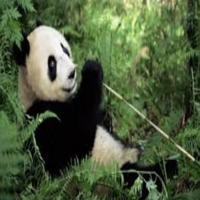

[{'狮子': 0.9841931462287903}]


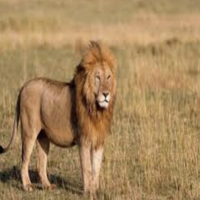

In [3]:
import paddlehub as hub
import cv2
from PIL import Image
from IPython.display import display

# 初始化分类器
classifier = hub.Module(name="resnet50_vd_animals")

# 调用分类器识别图片
result = classifier.classification(images=[cv2.imread('panda.png')])
print(result)  # 国宝大熊猫
display(Image.open('panda.png').resize([200, 200]))

result = classifier.classification(images=[cv2.imread('lion.png')])
print(result)  # 狮子
display(Image.open('lion.png').resize([200, 200]))

### 4. 搜索百科结果
这里根据识别结果从百度百科搜索百科解答，也可以使用维基百科等，只需要简单修改爬虫规则。具体的爬虫规则不在本文范围，这里不细讲原理，直接放出可用代码。

#### 4.1 在百度百科搜索识别出的动物

In [4]:
import requests
from requests_html import HTMLSession

word = list(result[0].keys())[0]  # 提取动物类别名称

# 由于对于大熊猫返回结果中有国宝二字，从纯科学角度讲并不是分类学的准确类别，而且百度百科搜索“国宝大熊猫”得到的也不是“大熊猫”的真正百科；
# 因此将类别中的国宝二字去掉，剩余部分作为搜索关键词。
word = word.replace('国宝', '')  # 对不含国宝二字的类别，如狮子，没有影响
url = f'https://baike.baidu.com/search?word={word}&pn=0&rn=0&enc=utf8'  # 百度百科搜索链接
print(f'在百度百科搜索动物名称：{url}')  # 打印搜索链接

# 模拟浏览器，设置headers
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

session = HTMLSession()  # 初始化爬虫

response = session.get(url=url, headers=headers)  # 爬取搜索结果
assert response.status_code==200, '网络有问题，请检查网络连接后再试'  # 200表示正常

# 从搜索结果中获取第一个结果对应的网页链接
content = response.html.find('a.result-title', first=True)
content_url = content.xpath('//a/@href')[0]  # 百科内容对应网页链接
print(f'百度百科搜索结果中第一条链接：{content_url}')

在百度百科搜索动物名称：https://baike.baidu.com/search?word=狮子&pn=0&rn=0&enc=utf8
百度百科搜索结果中第一条链接：http://baike.baidu.com/item/%E7%8B%AE%E5%AD%90/66440


#### 4.2 从百度百科页面提取百科文字信息

In [5]:
response = session.get(url=content_url, headers=headers)  # 爬取百科页面内容
assert response.status_code==200, '网络有问题，请检查网络连接后再试'  # 200表示正常

text = response.html.find('div.para')  # 解析网页内容，提取正文信息
i = 0
final_text = ''
for t in text:
    if final_text == '':
        final_text = t.text
    else:
        final_text = final_text + '\n' + t.text
    i += 1
    if i>10:
        # 最多展示十段内容，超出部分不要
        break

print(final_text)

狮子（学名：Panthera leo；英文名：Lion）：简称狮，中国古称狻猊。是一种生存在非洲与亚洲的大型猫科动物，是现存平均体重最大的猫科动物，也是在世界上唯一一种雌雄两态的猫科动物。
狮子体型大，躯体均匀，四肢中长，趾行性。头大而圆，吻部较短，视、听、嗅觉均很发达。犬齿及裂齿极发达；上裂齿具三齿尖，下裂齿具2齿尖；臼齿较退化，齿冠直径小于外侧门齿高度。皮毛柔软。前足5趾，后足4趾；爪锋利，可伸缩。尾较发达。有“草原之王”的称号，是非洲顶级的猫科食肉动物。野生非洲雄狮平均体重200千克，肩高1.2米，全长可达3.2米。狮子的毛发短，体色有浅灰、黄色或茶色，雄狮还长有很长的鬃毛，鬃毛有淡棕色、深棕色、黑色等等，长长的鬃毛一直延伸到肩部和胸部。
生活在热带稀树草原和草地，也出现于灌木和旱林。肉食，常以伏击方式捕杀其他温血动物。分布于非洲草原、亚洲印度。在野外狮子活10到14年，圈养下更长寿，一般达二十余年。 [1]
（概述图片参考资料来源： [2]  ）
狮子(22张)
狮子是大型猫科动物，科学家根据其进化轨迹得出结论，该物种起源于约12万年前。英国《BMC进化生物学》杂志刊登的这项最新成果由英国、美国、法国和澳大利亚等国研究人员共同完成。他们从分布在世界各地博物馆中的古代狮子标本中取样，包括已经灭绝的北非巴巴里狮、伊朗狮等。研究人员对它们进行了基因测序，并将测序结果与现有的亚洲狮、非洲狮进行比对，得出了现代狮子的进化路线图。 [4]
结果显示，狮子起源于约12.4万年前的非洲东部和南部，大约2.1万年前，狮子才开始走出非洲，最远抵达亚洲的印度等地。从分支来看，现代狮子主要分为非洲东部、南部的一支和非洲中部、西部及印度的一支。后者已处于濒危状态，这意味着狮子面临着基因多样性减损一半的风险。 [4]
在过去几十年来，生活在非洲中、西部的狮子数量大幅减少，这项新研究从基因多样性的角度说明，应该对这一支狮子加强保护，以维持整个狮子种群的生存和发展。 [4]
开普狮和巴巴里狮是灭绝的两个亚种，开普狮灭绝于19世纪，没有留下任何可靠记录。巴巴里狮灭绝于上世纪前期，但动物园里还有一部分笼养的巴巴里狮，它们鬃毛更加发达，一直延伸到背部和腹部。巴巴里狮的最后阵地是摩洛哥的阿特拉斯山脉，1922年，最后一只巴巴里狮是被人类的猎枪击倒。位于印度的亚洲狮体型比非洲兄弟要小，鬃毛也比较短。

### 5. 封装应用接口

In [6]:
def animal_baike(img_path, text_length=5):
    """
    img_path: 图片路径
    text_length: 返回的说明文字最大段落数，default 5
    """
    import paddlehub as hub
    import cv2
    from PIL import Image
    from IPython.display import display
    import requests
    from requests_html import HTMLSession

    # 初始化分类器
    classifier = hub.Module(name="resnet50_vd_animals")

    # 调用分类器识别图片
    result = classifier.classification(images=[cv2.imread(img_path)])
    word = list(result[0].keys())[0]  # 提取动物类别名称
    # 由于对于大熊猫返回结果中有国宝二字，从纯科学角度讲并不是分类学的准确类别，而且百度百科搜索“国宝大熊猫”得到的也不是“大熊猫”的真正百科；
    # 因此将类别中的国宝二字去掉，剩余部分作为搜索关键词。
    word = word.replace('国宝', '')  # 对不含国宝二字的类别，如狮子，没有影响
    url = f'https://baike.baidu.com/search?word={word}&pn=0&rn=0&enc=utf8'  # 百度百科搜索链接

    # 模拟浏览器，设置headers
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    session = HTMLSession()  # 初始化爬虫
    response = session.get(url=url, headers=headers)  # 爬取搜索结果
    assert response.status_code==200, '网络有问题，请检查网络连接后再试'  # 200表示正常

    # 从搜索结果中获取第一个结果对应的网页链接
    content = response.html.find('a.result-title', first=True)
    content_url = content.xpath('//a/@href')[0]  # 百科内容对应网页链接
    response = session.get(url=content_url, headers=headers)  # 爬取百科页面内容
    assert response.status_code==200, '网络有问题，请检查网络连接后再试'  # 200表示正常

    text = response.html.find('div.para')  # 解析网页内容，提取正文信息
    i = 0
    final_text = ''
    for t in text:
        if final_text == '':
            final_text = t.text
        else:
            final_text = final_text + '\n' + t.text
        i += 1
        if i>text_length:
            # 最多展示text_length段内容，超出部分不要
            break
    display(Image.open(img_path).resize([200, 200]))
    print(result)
    print(final_text)

### 6. 测试整体接口

[2020-08-25 15:19:48,806] [    INFO] - Installing resnet50_vd_animals module
[2020-08-25 15:19:49,086] [    INFO] - Module resnet50_vd_animals already installed in /home/aistudio/.paddlehub/modules/resnet50_vd_animals


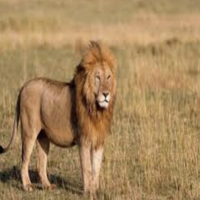

[{'狮子': 0.9841931462287903}]
狮子（学名：Panthera leo；英文名：Lion）：简称狮，中国古称狻猊。是一种生存在非洲与亚洲的大型猫科动物，是现存平均体重最大的猫科动物，也是在世界上唯一一种雌雄两态的猫科动物。
狮子体型大，躯体均匀，四肢中长，趾行性。头大而圆，吻部较短，视、听、嗅觉均很发达。犬齿及裂齿极发达；上裂齿具三齿尖，下裂齿具2齿尖；臼齿较退化，齿冠直径小于外侧门齿高度。皮毛柔软。前足5趾，后足4趾；爪锋利，可伸缩。尾较发达。有“草原之王”的称号，是非洲顶级的猫科食肉动物。野生非洲雄狮平均体重200千克，肩高1.2米，全长可达3.2米。狮子的毛发短，体色有浅灰、黄色或茶色，雄狮还长有很长的鬃毛，鬃毛有淡棕色、深棕色、黑色等等，长长的鬃毛一直延伸到肩部和胸部。
生活在热带稀树草原和草地，也出现于灌木和旱林。肉食，常以伏击方式捕杀其他温血动物。分布于非洲草原、亚洲印度。在野外狮子活10到14年，圈养下更长寿，一般达二十余年。 [1]
（概述图片参考资料来源： [2]  ）
狮子(22张)
狮子是大型猫科动物，科学家根据其进化轨迹得出结论，该物种起源于约12万年前。英国《BMC进化生物学》杂志刊登的这项最新成果由英国、美国、法国和澳大利亚等国研究人员共同完成。他们从分布在世界各地博物馆中的古代狮子标本中取样，包括已经灭绝的北非巴巴里狮、伊朗狮等。研究人员对它们进行了基因测序，并将测序结果与现有的亚洲狮、非洲狮进行比对，得出了现代狮子的进化路线图。 [4]
结果显示，狮子起源于约12.4万年前的非洲东部和南部，大约2.1万年前，狮子才开始走出非洲，最远抵达亚洲的印度等地。从分支来看，现代狮子主要分为非洲东部、南部的一支和非洲中部、西部及印度的一支。后者已处于濒危状态，这意味着狮子面临着基因多样性减损一半的风险。 [4]


In [7]:
animal_baike('lion.png')

[2020-08-25 15:19:51,213] [    INFO] - Installing resnet50_vd_animals module
[2020-08-25 15:19:51,215] [    INFO] - Module resnet50_vd_animals already installed in /home/aistudio/.paddlehub/modules/resnet50_vd_animals


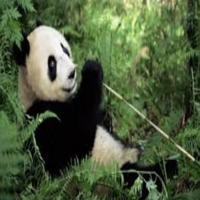

[{'国宝大熊猫': 0.9382492899894714}]
大熊猫（学名：Ailuropoda melanoleuca）：属于食肉目、熊科、大熊猫亚科和大熊猫属唯一的哺乳动物。仅有二个亚种。雄性个体稍大于雌性。体型肥硕似熊、丰腴富态，头圆尾短，头躯长1.2-1.8米，尾长10-12厘米。体重80-120千克，最重可达180千克，体色为黑白两色，脸颊圆，有大的黑眼圈，标志性的内八字的行走方式，也有解剖刀般锋利的爪子。大熊猫皮肤厚，最厚处可达10毫米。黑白相间的外表，有利于隐蔽在密林的树上和积雪的地面而不易被天敌发现。
生活在海拔2600-3500米的茂密竹林里，那里常年空气稀薄，云雾缭绕，气温低于20℃。有充足的竹子，地形和水源的分布利于该物种建巢藏身和哺育幼仔。大熊猫善于爬树，也爱嬉戏。爬树的行为一般是临近求婚期，或逃避危险，或彼此相遇时弱者借以回避强者的一种方式。大熊猫每天除去一半进食的时间，剩下的一半时间多数便是在睡梦中度过。在野外，大熊猫在每两次进食的中间睡2-4个小时。大熊猫99%的食物都是竹子，可供大熊猫食用的竹类植物共有12属、60多种。野外大熊猫的寿命为18-20岁，圈养状态下可以超过30岁。
大熊猫已在地球上生存了至少800万年，被誉为“活化石”和“中国国宝”，世界自然基金会的形象大使，是世界生物多样性保护的旗舰物种。截至2019年11月，全球圈养大熊猫种群数量达到600只。 [1]
大熊猫是中国特有种，主要栖息地是中国四川、陕西和甘肃的山区。
（概述图参考来源： [2]  ）
大熊猫的历史可谓源远流长。迄今所发现的最古老大熊猫成员——始熊猫的化石出土于中国云南禄丰和元谋两地，地质年代约为800万年前中新世晚期。在长期严酷的生存竞争和自然选择中，和它们同时代的很多动物都已灭绝，但大熊猫却是强者，处于优势，生存至今成为“活化石”。 [5]


In [8]:
animal_baike('panda.png')

### 7. 总结
本文主要介绍了三方面内容：
- 1. 如何调用PaddleHub的动物识别模型对给定图片的动物分类；
- 2. 如何调用requests及相关库在百度百科搜索相关动物介绍；
- 3. 如何将相关代码打包为一个完整功能的接口函数，只需要输入图片路径即可显示图片、分类结果及相关介绍

一个非常简单的**动物百科AI老师**就完成了。现在都是一只动物在图里，如果有多只，甚至多种动物会怎样呢？快来尝试不同的图片吧，看看有什么不一样的结果，试试改进这个AI老师吧！